# Traits and Plant Growth Rates

We have two datasets: 1) basal area each year from 2006 to 2011 and 2) plant and environmental traits for each tree. Below, I aim to examine the data - assess data types, check for missingness, normality, outliers. Depndeding on the degree of missingness, I will impute the data as we would like to keep as many observations as possible.

## Table of Contents
* Initial Assessment
* Imputation
* Data Exploration
* Conclusion

## Initial Assessment

I will assess the data classes (at each column),  missingness, whether the data are normal and the shape.

In [1]:
RGR.Raw <- data.frame(read.csv("C:/Users/jodyn/OneDrive/Github/Trait-Performance-Relationships/data/RGR.csv"))
MSH.Raw <- data.frame(read.csv("C:/Users/jodyn/OneDrive/Github/Trait-Performance-Relationships/data/MSH all data_July2015.csv"))

In [2]:
data_classes <- function(df){
    # given a dataframe, df, print the class of each column #
    df_class <- sapply(1:ncol(df), function (x) class(df[,x]))
    df_class <- data.frame(Variable = colnames(df), Class = df_class)
    cat("Class of each column\n\n")
    print(df_class)                  
}

In [3]:
data_classes(RGR.Raw)

Class of each column

   Variable   Class
1  SampleID  factor
2 BA.0.2006 numeric
3 BA.0.2007 numeric
4 BA.0.2008 numeric
5 BA.0.2009 numeric
6 BA.0.2010 numeric
7 BA.0.2011 numeric


Good, the only data being read as factors are the sampleIDs.

In [4]:
data_classes(MSH.Raw)

Class of each column

                  Variable   Class
1                Sample.ID  factor
2         Height.DBH.Ratio numeric
3                    Estem numeric
4                    Etwig numeric
5       Branching.Distance numeric
6            Twig.Diameter numeric
7        Twig.Wood.Density numeric
8        Stem.Wood.Density numeric
9       Leaf.Mass.Fraction numeric
10               Leaf.Area numeric
11                     LMA numeric
12                     LCC numeric
13                     LNC numeric
14                     LPC numeric
15                    d15N numeric
16                    t.b2 numeric
17                      Ks numeric
18                   Ktwig numeric
19             Huber.Value numeric
20                   X.Lum numeric
21                      VD numeric
22               X.Sapwood numeric
23                    d13C numeric
24                Biomass5 numeric
25          pcent.max.Bio5 numeric
26   Symmetric.Competition numeric
27  Asymmetric.Competition numeri

Most of the trait data are numeric. The exceptions are site ID, sample ID, and species. 

In [5]:
data_missingness <- function(df){
    # given a dataframe, df, find the % and count of missing values (coded as NAs)
    # print the result
    data_missing_percentage <- sapply(1:ncol(df), function (x){
        sum(is.na(df[,x]))/nrow(df)*100})
    data_missing_count <- sapply(1:ncol(df), function (x){
        sum(is.na(df[,x]))})
    data_missing <- data.frame(Variable = colnames(df), Missing_Percent = data_missing_percentage,
                              Missing_Total = data_missing_count)
    cat("Percentage of observations missing from column\n\n")
    print(data_missing)
    cat("Mean % missing:", mean(data_missing[,2]),
       "\nTotal missing:", sum(data_missing[,3]))} 

In [6]:
data_missingness(RGR.Raw)

Percentage of observations missing from column

   Variable Missing_Percent Missing_Total
1  SampleID        0.000000             0
2 BA.0.2006        2.278481             9
3 BA.0.2007        2.531646            10
4 BA.0.2008        2.531646            10
5 BA.0.2009        2.531646            10
6 BA.0.2010        2.531646            10
7 BA.0.2011        2.278481             9
Mean % missing: 2.097649 
Total missing: 58

Only a small portion of the data are missing. But, most of the missingness is from 2007 to 2010. I need (atleast) 2006 and 2007 to measure growth rates. Maybe, imputations are an option. I will need to compare fit and see if that works. If not, we will just need to remove these rows. 

In [7]:
data_missingness(MSH.Raw)

Percentage of observations missing from column

                  Variable Missing_Percent Missing_Total
1                Sample.ID        0.000000             0
2         Height.DBH.Ratio        0.000000             0
3                    Estem        0.000000             0
4                    Etwig        0.000000             0
5       Branching.Distance        0.000000             0
6            Twig.Diameter        0.000000             0
7        Twig.Wood.Density        0.000000             0
8        Stem.Wood.Density        0.000000             0
9       Leaf.Mass.Fraction        0.000000             0
10               Leaf.Area        0.000000             0
11                     LMA        0.000000             0
12                     LCC        0.000000             0
13                     LNC        0.000000             0
14                     LPC        0.000000             0
15                    d15N        0.000000             0
16                    t.b2        1.7721

A larger chunk of missingness from this dataframe. I will probably exclude columns with missingness greater than 50%. They are not worth trying to impute.

Since the data are non-normal, I will use predictive mean matching to impute the data (method = "ppm" in the mice package). I will also try robust EMbased imputation method in the VIM package (irmi).

In [8]:
library(e1071)

data_normality <- function(df){
    # given a dataframe, df, find the skewness and kurtosis and test for normality
    # but only include numeric columns
    col_list <- colnames(df)[which(sapply(1:ncol(df), function (x){is.numeric(df[,x])}))]
    data_skewness <- sapply(col_list, function (x){
        skewness(df[,x], na.rm = TRUE)})
    data_kurtosis <- sapply(col_list, function (x){
        kurtosis(df[,x], na.rm = TRUE)})
    data_normality <- sapply(col_list, function (x){
        shapiro.test(df[,x])})[1:2,]
    data_shape <- data.frame(Skewness = data_skewness,
                              Kurtosis = data_kurtosis, Shapiro_Test_W = as.numeric(unname(data_normality[1,])),
                            Shapiro_Test_pvalue = as.numeric(unname(data_normality[2,])))
    cat("Kurtosis, skewness & test for normality for each numeric column\n\n")
    print(data_shape)} 

Warning message:
"package 'e1071' was built under R version 3.6.3"

In [9]:
data_normality(RGR.Raw)

Kurtosis, skewness & test for normality for each numeric column

          Skewness Kurtosis Shapiro_Test_W Shapiro_Test_pvalue
BA.0.2006 2.205066 9.575192      0.8302604        6.727060e-20
BA.0.2007 1.974834 7.857950      0.8529547        1.531183e-18
BA.0.2008 1.732066 6.132620      0.8758313        4.888132e-17
BA.0.2009 1.523144 4.706086      0.8950752        1.313185e-15
BA.0.2010 1.401437 3.873564      0.9068659        1.226322e-14
BA.0.2011 1.273092 2.774428      0.9164002        8.264971e-14


In [10]:
data_normality(MSH.Raw)

Kurtosis, skewness & test for normality for each numeric column

                           Skewness    Kurtosis Shapiro_Test_W
Height.DBH.Ratio         0.61513858  0.36014192      0.9756856
Estem                    1.93601520  5.09889246      0.8265319
Etwig                    0.97278329  1.03804501      0.9434106
Branching.Distance       2.16421081  4.43289855      0.7139592
Twig.Diameter            1.99468523  5.70416006      0.8378735
Twig.Wood.Density       -0.40711246 -0.10137377      0.9851752
Stem.Wood.Density       -0.06266277 -0.81071742      0.9816907
Leaf.Mass.Fraction       0.87366639  0.42557354      0.9446927
Leaf.Area                2.79970650  8.41053692      0.6228780
LMA                      0.97713603  0.17666176      0.9035701
LCC                     -0.26548002 -0.19990420      0.9848028
LNC                      0.25376965 -0.11819716      0.9931637
LPC                      1.38658799  3.53654122      0.9167004
d15N                     0.99975400  4.53980921      

In [11]:
library(tidyr) 
library(ggplot2)
library(hrbrthemes)
library(extrafont)
library(vegan)
library(gridExtra)
library(randomcoloR)

data_distribution <- function(df){
    # given a dataframe, df, plot a density histogram and density plot
    # the number of plots can differ between plots, so this function will vary the number of
    # plots within a grid arrange object

    col_list <- colnames(df)[which(sapply(1:ncol(df), function (x){is.numeric(df[,x])}))]
    colour_list <- distinctColorPalette(k = length(col_list))
    df_numeric <- df[, col_list]
    df_long <- gather(df_numeric , key = "group", value = "value")
    df_hist_density <- list()
    for (i in 1:length(col_list)){
        df_hist_density[[i]] <- 
            ggplot(subset(df_long,group == col_list[i]), aes(x = value)) +
            geom_histogram(aes (y = ..density..), color = colour_list[i], fill = colour_list[i],
                           position = "identity", alpha = 0.5, bins = 50)+
            geom_density(aes(fill = NULL), color = colour_list[i], alpha = 0.5)+
            labs( x = " ", y = col_list[i])+
            theme_bw() +
            theme(legend.position = "none")}
    if (length(col_list)<7){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density, ncol = 2)))}
    else if(length(col_list)<13){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:6)], ncol = 2)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(7:length(df_hist_density))], ncol = 2)))
        }
    else if(length(col_list)<19){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:9)], ncol = 3)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(10:length(df_hist_density))], ncol = 3)))
        }
    else if(length(col_list)<25){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(12:length(df_hist_density))], ncol = 4)))}
     else if(length(col_list)<37){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(13:24)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(25:length(df_hist_density))], ncol = 4)))}
    else if(length(col_list)<49){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(13:24)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(25:36)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(37:length(df_hist_density))], ncol = 4)))}
    else if(length(col_list)<61){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(13:24)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(25:36)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(37:48)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(49:length(df_hist_density))], ncol = 4)))}
    else if(length(col_list)<73){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(13:24)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(25:36)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(37:48)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(49:60)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(61:length(df_hist_density))], ncol = 4)))}
}

Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'hrbrthemes' was built under R version 3.6.3"Warning message:
"package 'extrafont' was built under R version 3.6.2"Registering fonts with R
Warning message:
"package 'vegan' was built under R version 3.6.3"Loading required package: permute
Warning message:
"package 'permute' was built under R version 3.6.3"Loading required package: lattice
This is vegan 2.5-6
Warning message:
"package 'gridExtra' was built under R version 3.6.3"Warning message:
"package 'randomcoloR' was built under R version 3.6.3"

TableGrob (3 x 2) "arrange": 6 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]
6 6 (3-3,2-2) arrange gtable[layout]


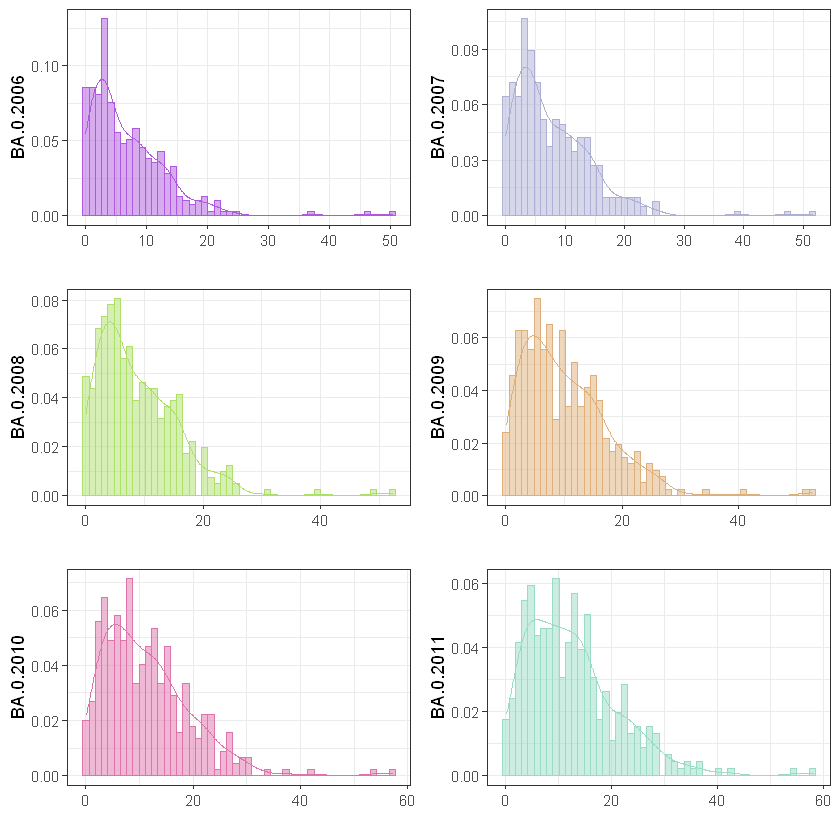

In [12]:
data_distribution(RGR.Raw)

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


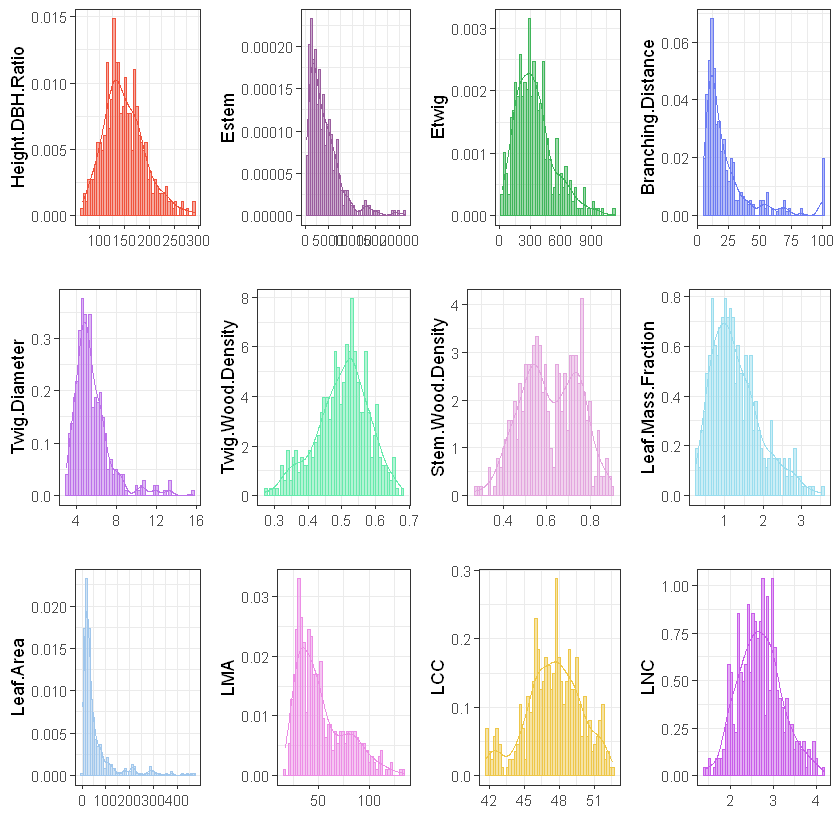

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


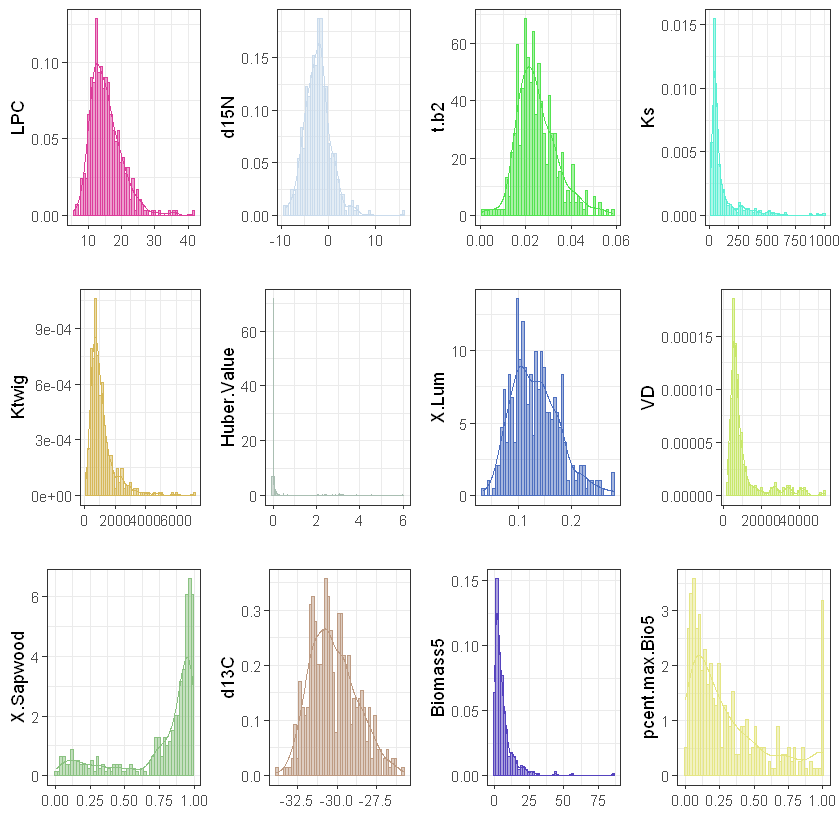

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


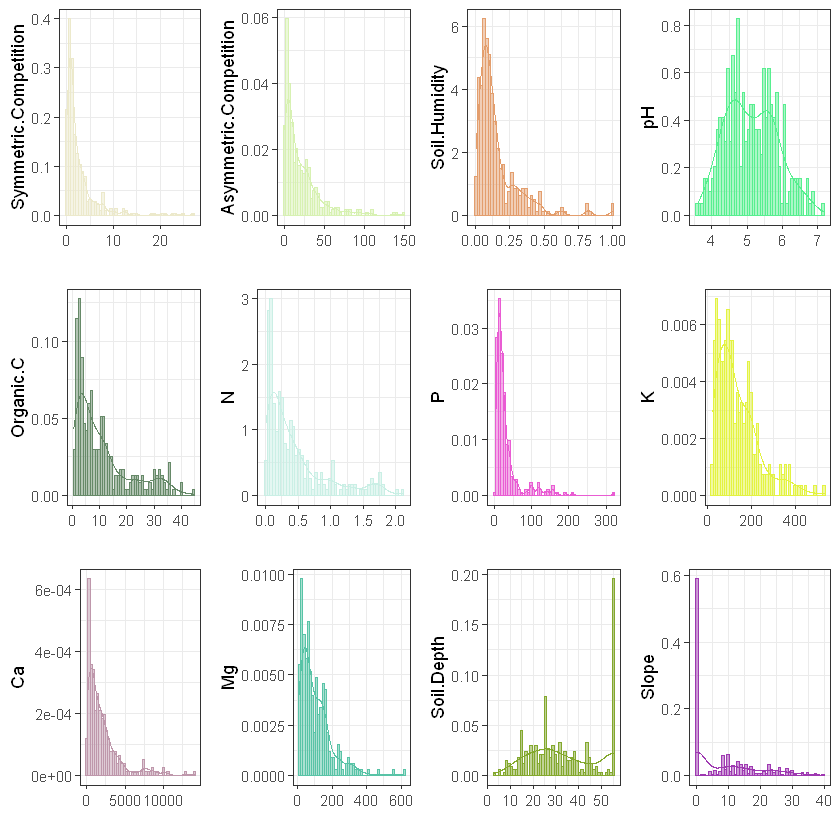

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


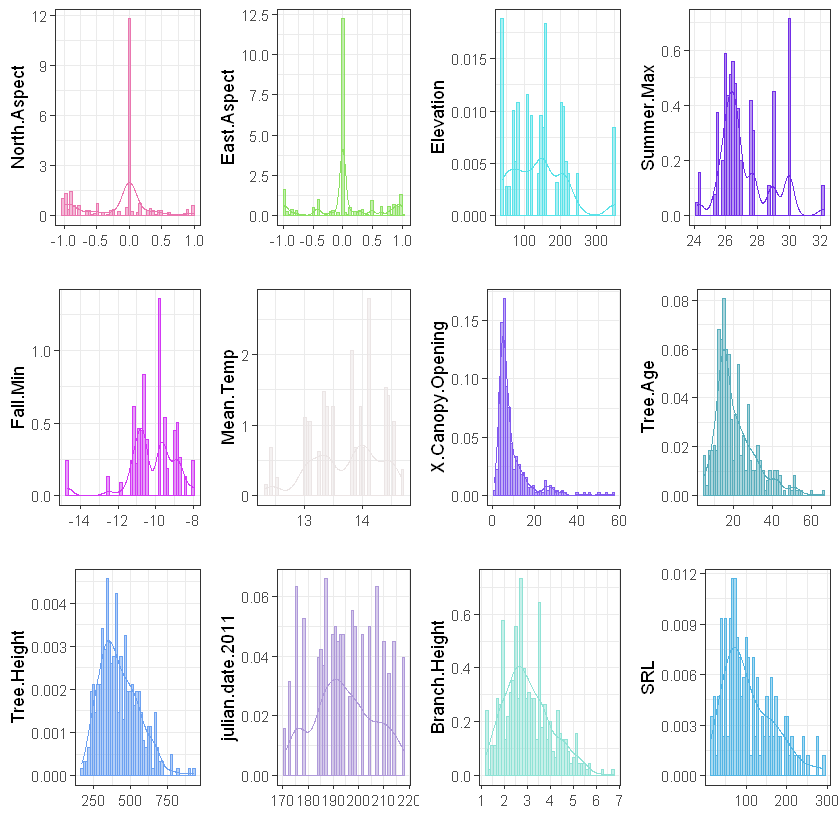

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


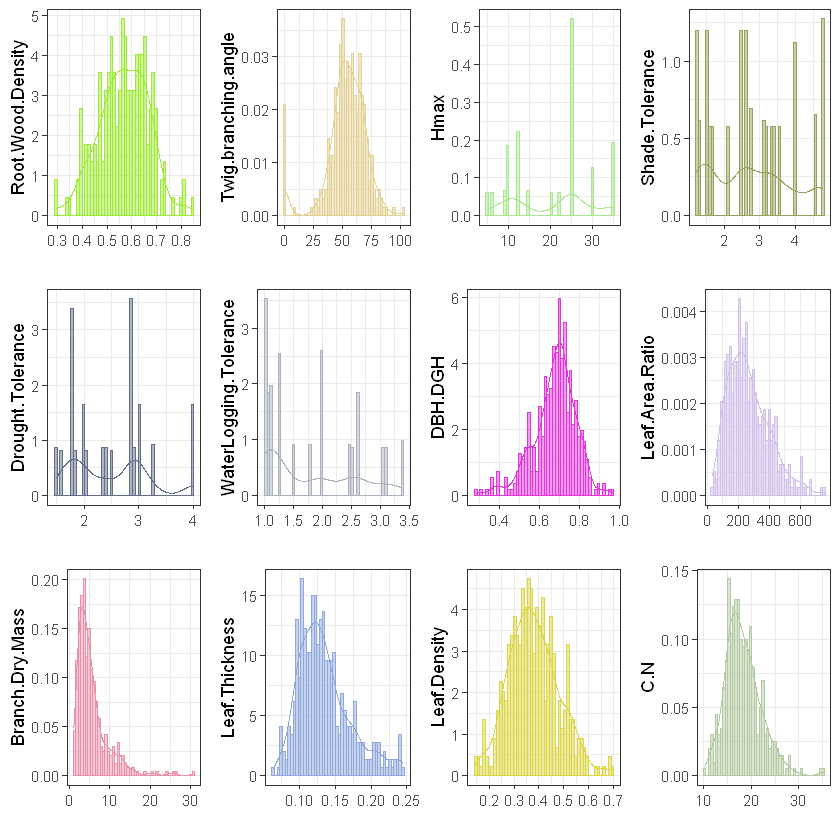

TableGrob (2 x 4) "arrange": 7 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]
4 4 (1-1,4-4) arrange gtable[layout]
5 5 (2-2,1-1) arrange gtable[layout]
6 6 (2-2,2-2) arrange gtable[layout]
7 7 (2-2,3-3) arrange gtable[layout]


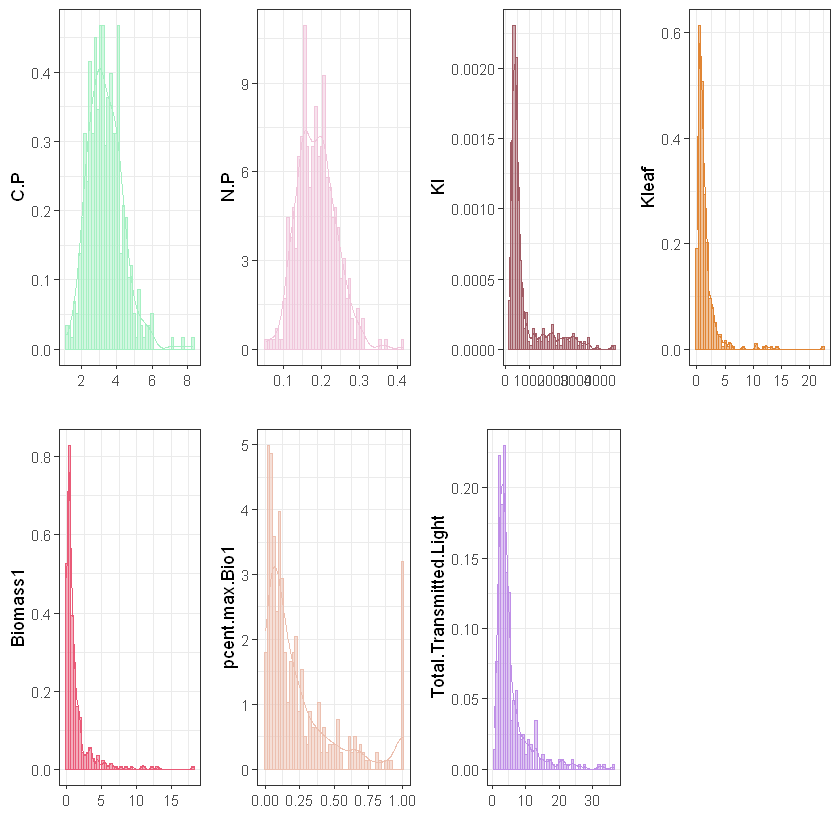

In [13]:
data_distribution(MSH.Raw)

After doing some reading, it seems as though the  robust EMbased imputation method (VIM) performs well for imputation. But the data are generally non-normal and this methods uses an OLS. I will still simply use ppm. I read that m = 5 is usually enough.  

In [14]:
library(mice)
library(mvnormtest)
library(RVAideMemoire)

Warning message:
"package 'mice' was built under R version 3.6.3"
Attaching package: 'mice'

The following objects are masked from 'package:base':

    cbind, rbind

Warning message:
"package 'mvnormtest' was built under R version 3.6.3"Warning message:
"package 'RVAideMemoire' was built under R version 3.6.3"*** Package RVAideMemoire v 0.9-77 ***

Attaching package: 'RVAideMemoire'

The following object is masked from 'package:mvnormtest':

    mshapiro.test



Might be best to just drop some the columns trait values with a large % of missing data. 

For the trait data, I will simply remove those with a majority of missing cases before running the imputation - I am thinking of using a cut of less than 50%. 

In [15]:
# removing cases with a bunch of zeroes
MSH.50 <- MSH.Raw[,names(which(sapply(colnames(MSH.Raw), function (x) {sum(is.na(MSH.Raw[,x]))/nrow(MSH.Raw)<0.5})))]

In [16]:
# I only want columns that are numeric
numeric_columns_msh <- suppressWarnings(which(apply(MSH.50,2, function (x) !is.na(mean(as.numeric(x), na.rm = TRUE)))))
numeric_columns_rgr <- suppressWarnings(which(apply(RGR.Raw,2, function (x) !is.na(mean(as.numeric(x), na.rm = TRUE)))))

In [ ]:
MSH.IP.MICE <- mice(data.matrix(MSH.50[,numeric_columns_msh]), 
               printFlag=FALSE, method = "pmm", m = 5, seed = 300)

In [ ]:
RGR.IP.MICE <- mice(data.matrix(RGR.Raw[,numeric_columns_rgr]), 
               printFlag=FALSE, method = "pmm", m = 5, seed = 300)

Now, I will run the imputation on these data. Since I have removed the columns with a large amount of missing cases, the imputation should work. If not, I will set a more stringent condition. 

In [ ]:
# fit a lm and see if results are comparable between mice output and raw data
fit.base_msh = lm(Tree.Height ~ Soil.Depth + Biomass1, data = MSH.50)
summary(fit.base_msh)

In [ ]:
# build a model using dataset from mice, for all 5 of them
fit.mice_msh <- with(data = MSH.IP.MICE, exp = lm(Tree.Height ~ Soil.Depth + Biomass1))

# pool results together 
combFit_msh <- pool(fit.mice_msh) 
# Note that the function pool() works for any object having BOTH coef() and vcov() methods, such as lm, glm and Arima, also for lme in nlme package.
summary(combFit_msh)

Some difference in regression coeffcients, but the same relationship and significance for trait data. I will use both datasets in the ML anyway.

In [ ]:
fit.base_rgr = lm(BA.0.2006 ~ BA.0.2010 + BA.0.2011, data = RGR.Raw)
summary(fit.base_rgr)

In [ ]:
fit.mice_rgr <- with(data = RGR.IP.MICE, exp = lm(BA.0.2006 ~ BA.0.2010 + BA.0.2011))

# pool results together 
combFit_rgr <- pool(fit.mice_rgr) 
# Note that the function pool() works for any object having BOTH coef() and vcov() methods, such as lm, glm and Arima, also for lme in nlme package.
summary(combFit_rgr)

No real difference in beta, and the same relationship and significance. I will use both datasets in the ML anyway.

# Growth Rate

# Conclusion